In [1]:
import logging
import shlex
import sys
from pathlib import Path
from typing import Dict, Tuple, Union

import elettra_toolbox
from cpymad.madx import Madx

LOGGER = logging.getLogger(name=__name__)
LOGGER.setLevel(logging.DEBUG)

handler = logging.StreamHandler(sys.stdout)
handler.setLevel(logging.DEBUG)
LOGGER.addHandler(handler)

import os
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from matplotlib import cm, gridspec, patches
from pyhdtoolkit import cpymadtools

plt.rcParams.update({"text.usetex": False})

In [2]:
if os.path.exists("stdout.out"):
    os.remove("stdout.out")

# Launch MAD-X Session
with open("stdout.out", "w") as f:
    madx = Madx(stdout=f)


# Read parameters

from config import parameters, settings

for i in parameters.keys():
    madx.globals[i] = parameters[i]


# Call sequence and optics

madx.call("elettra2_v15_VADER_2.3T.madx")
madx.call("optics_elettra2_v15_VADER_2.3T.madx")

# Set opt AB

k_ab_opt = 5.191616161616161
# Optimal value for the antibeands
madx.globals.k1_bqf1 = k_ab_opt
madx.globals.k1_bqf2 = k_ab_opt
madx.globals.k1_bqf3 = k_ab_opt
madx.globals.k1_bqf4 = k_ab_opt

# Initial twiss

madx.use(sequence="ring")
madx.twiss(sequence="ring", table="init_twiss")

# Compute Emittance

madx.input(
    f"""
emit, deltap={madx.globals.deltap};
emit, deltap={madx.globals.deltap};
"""
)

# Stop MAD-X instance

# madx.quit()

# Get the emittance from the standard output

ex, ey, ez = elettra_toolbox.get_emittances_from_madx_output("stdout.out", to_meters=True)


print(f"Emittance x : {ex*1e12} pm")

Emittance x : 164.33805 pm


In [6]:
# Check that the machine is closed

tol_x_survey, tol_z_survey =  elettra_toolbox.check_closed_machine(madx)

Running survey on the machine
Machine seems closed with respect to the provided tolerance (1.0 [mm])


2021-10-19 14:56:57.044 | INFO     | pyhdtoolkit.cpymadtools.plotters:plot_latwiss:638 - Plotting optics functions and machine layout
2021-10-19 14:56:57.044 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:plot_latwiss:639 - Getting Twiss dataframe from cpymad
2021-10-19 14:56:57.552 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:_make_elements_groups:1319 - Getting different element groups dframes from MAD-X twiss table
2021-10-19 14:56:57.638 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:_plot_machine_layout:1191 - Plotting machine layout
2021-10-19 14:56:58.908 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:plot_latwiss:665 - Plotting beta functions
2021-10-19 14:56:58.924 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:plot_latwiss:673 - Plotting dispersion functions
2021-10-19 14:56:58.949 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:plot_latwiss:691 - Setting xlim for longitudinal coordinate
2021-10-19 14:56:58.950 | INFO     | pyhdtoolkit.cpymadtools.plotters:plot_latwiss:695 - Savin

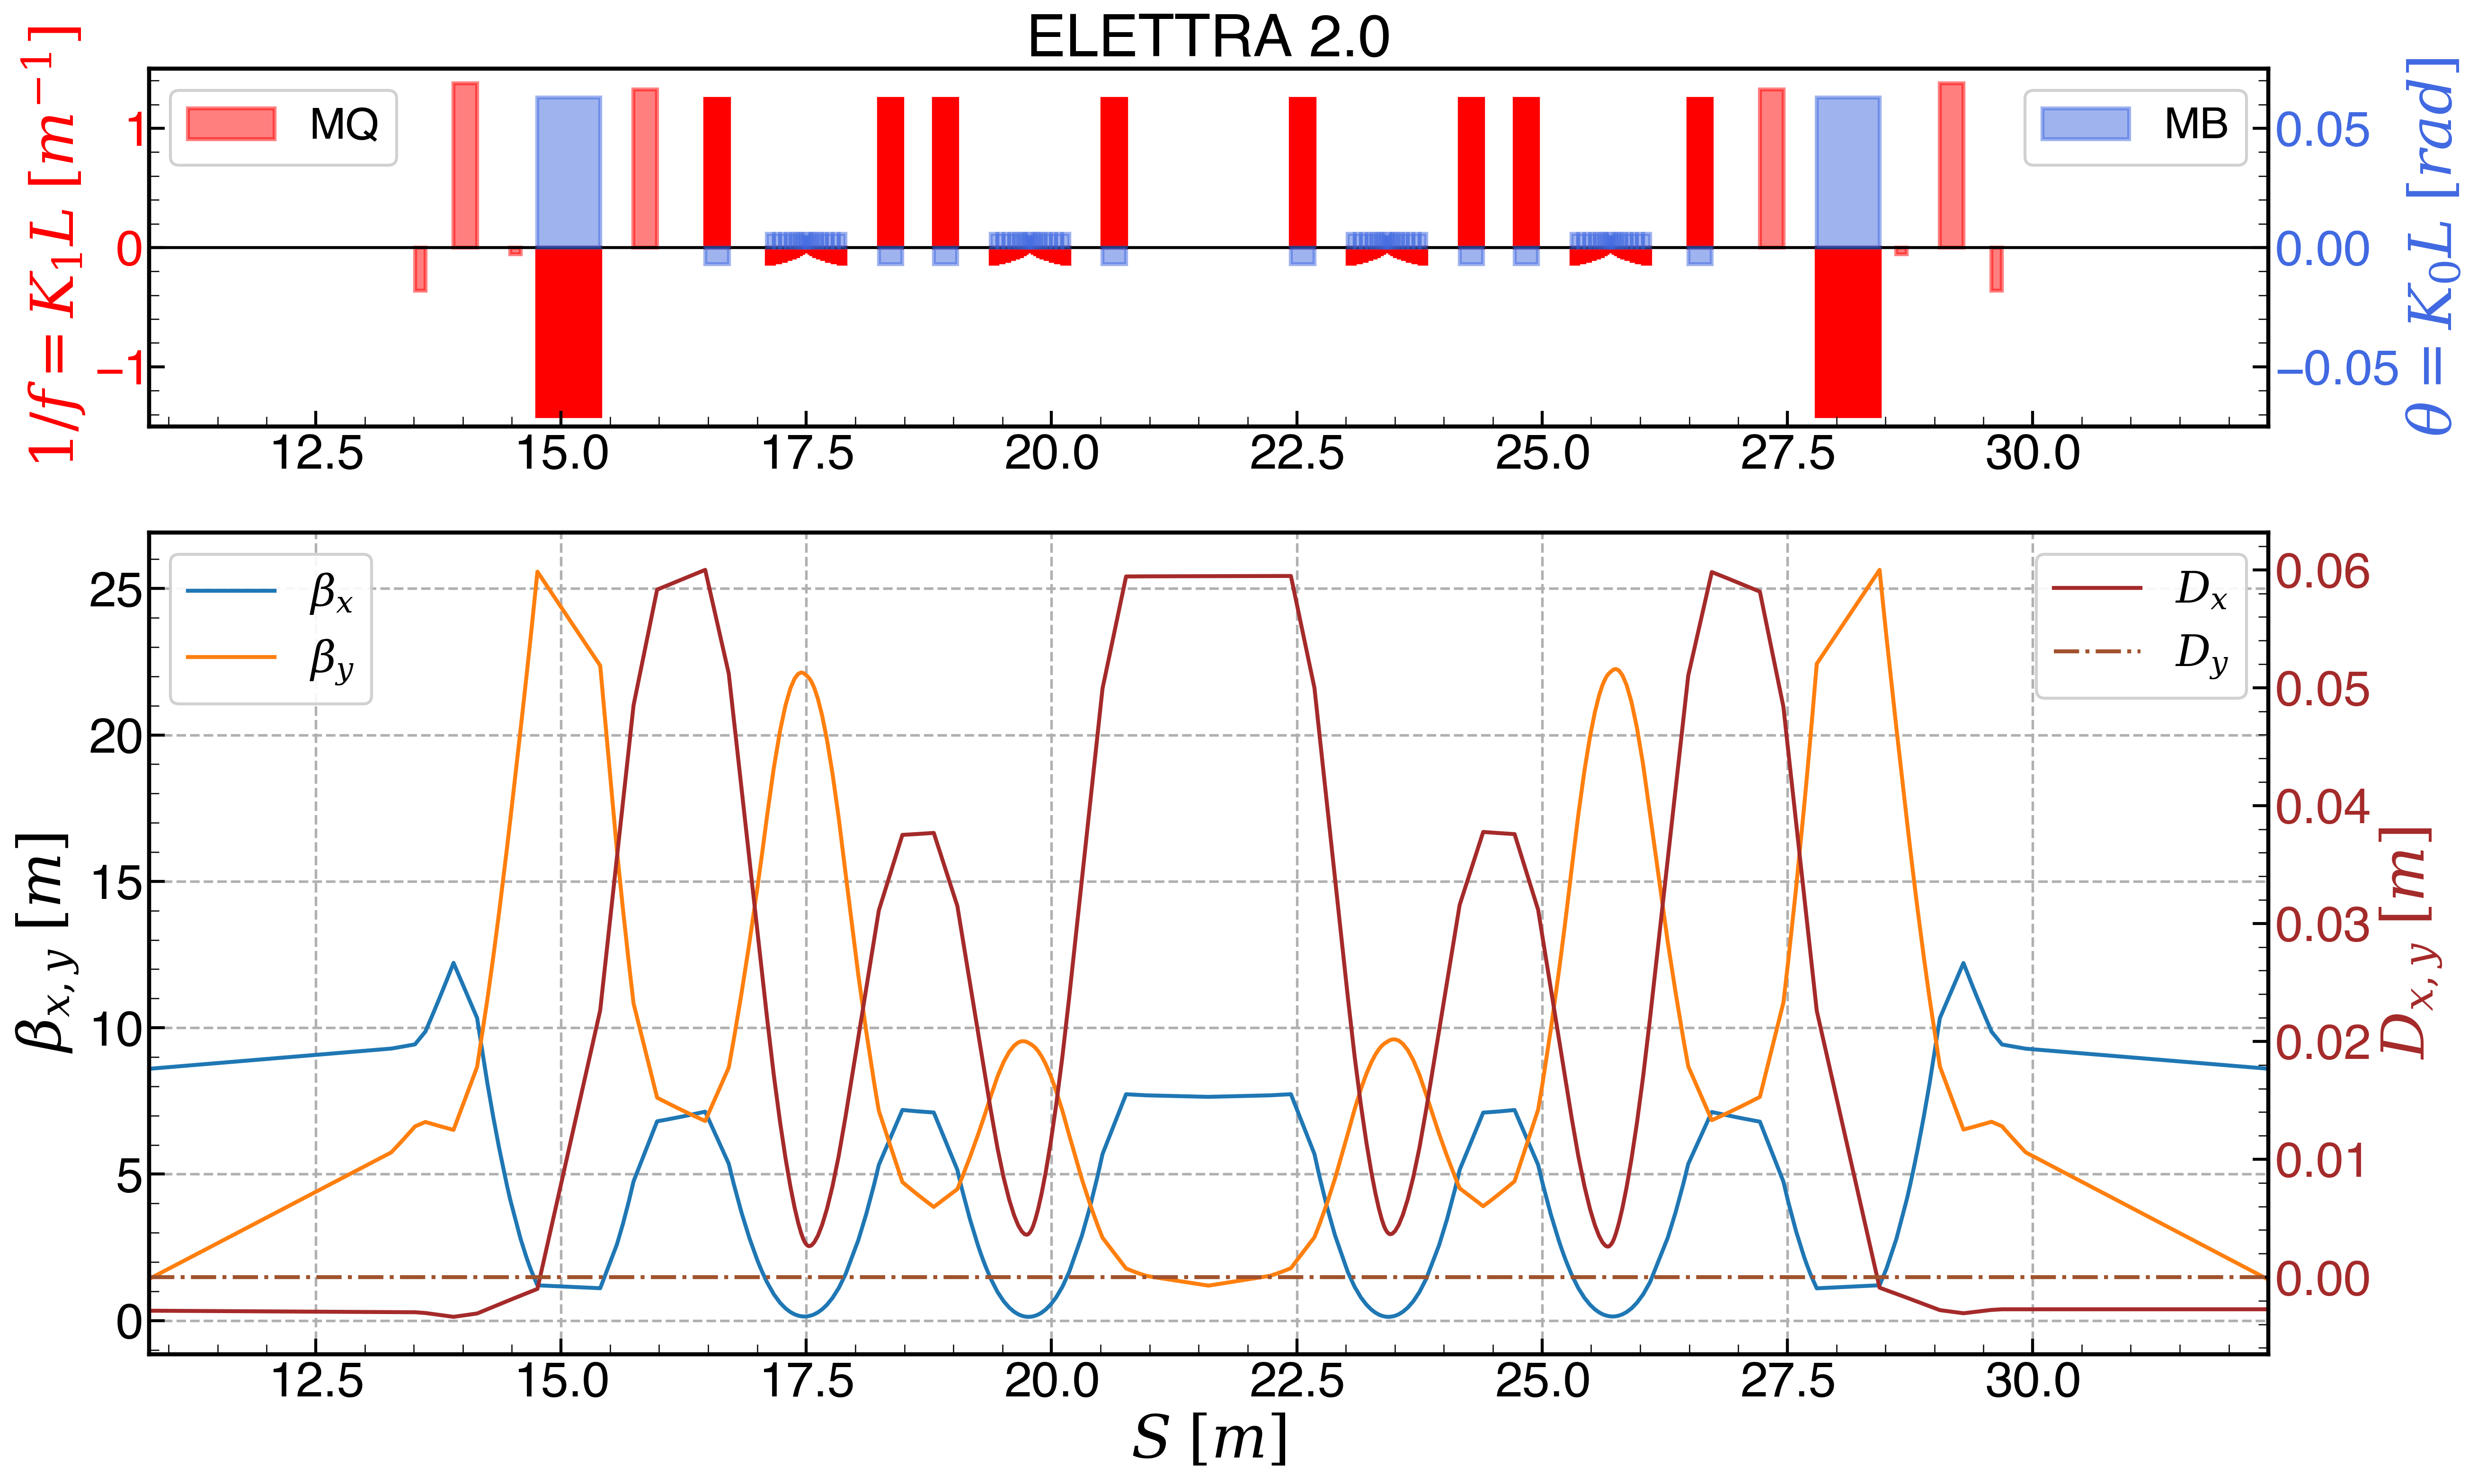

In [9]:
s_start = twiss[twiss.name == "ll:1"]["s"][0]
s_end = twiss[twiss.name == "ll:3"]["s"][0]

fig_lattice = cpymadtools.plotters.LatticePlotter.plot_latwiss(
    madx=madx,
    title="ELETTRA 2.0",
    xlimits=(s_start, s_end),
    disp_ylim=None,
    k0l_lim=(-75 * 1e-3, 75 * 1e-3),
    k1l_lim=(-1.5, 1.5),
    plot_dipole_k1=True,
    lw=2,
    savefig="before_match.pdf",
)

2021-10-19 14:57:18.086 | INFO     | pyhdtoolkit.cpymadtools.plotters:plot_latwiss:638 - Plotting optics functions and machine layout
2021-10-19 14:57:18.087 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:plot_latwiss:639 - Getting Twiss dataframe from cpymad
2021-10-19 14:57:18.583 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:_make_elements_groups:1319 - Getting different element groups dframes from MAD-X twiss table
2021-10-19 14:57:18.647 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:_plot_machine_layout:1191 - Plotting machine layout
2021-10-19 14:57:20.080 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:plot_latwiss:665 - Plotting beta functions
2021-10-19 14:57:20.097 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:plot_latwiss:673 - Plotting dispersion functions
2021-10-19 14:57:20.117 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:plot_latwiss:687 - Setting ylim for dispersion plot
2021-10-19 14:57:20.118 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:plot_latwiss:691 - Setting xlim 

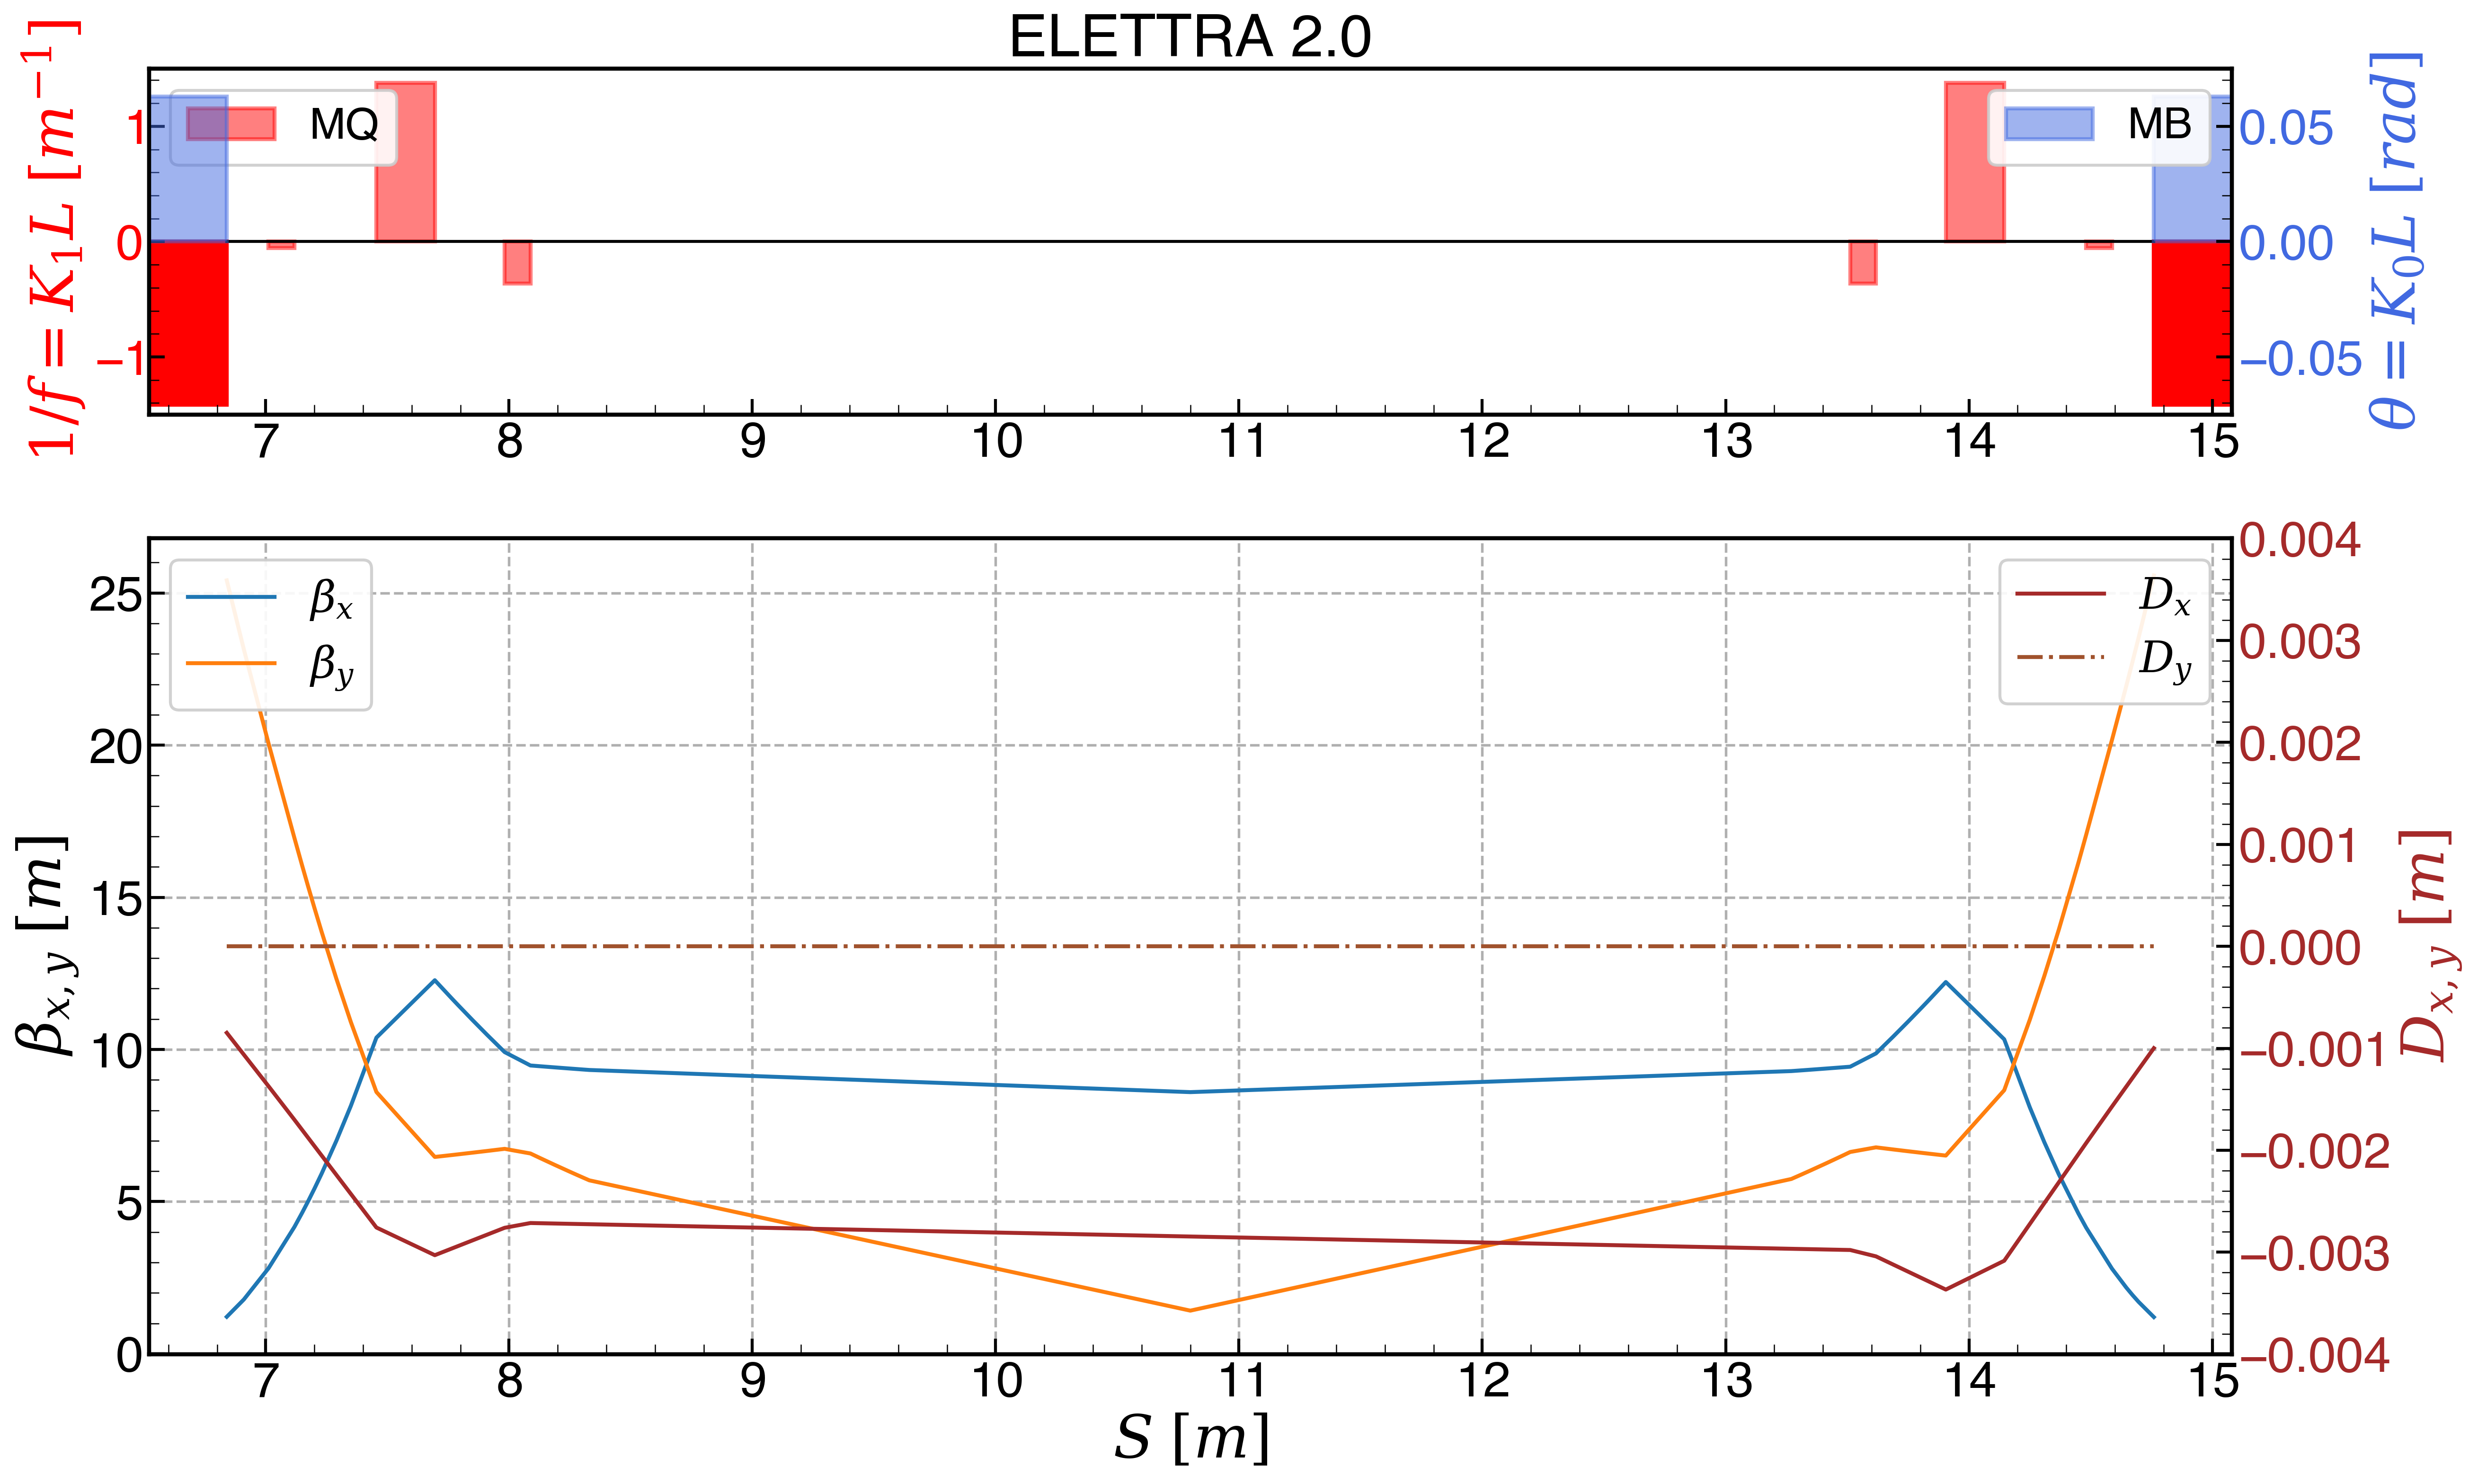

In [10]:
s_start = twiss[twiss.name == "bf1:1"]["s"][0] - twiss[twiss.name == "bf1:1"]["l"][0] / 2
s_end = twiss[twiss.name == "bf1:2"]["s"][0] - twiss[twiss.name == "bf1:2"]["l"][0] / 2

fig_lattice = cpymadtools.plotters.LatticePlotter.plot_latwiss(
    madx=madx,
    title="ELETTRA 2.0",
    xlimits=(s_start, s_end),
    disp_ylim=(-0.004, 0.004),
    k0l_lim=(-75 * 1e-3, 75 * 1e-3),
    k1l_lim=(-1.5, 1.5),
    plot_dipole_k1=True,
    lw=2,
)

In [11]:
# Matching the dispersion in the LL

madx.input(
    """
match, sequence=ring;
vary, name=k1_qd1, step=1e-6;
vary, name=k1_qf1, step=1e-6;
vary, name=k1_qd2, step=1e-6;
vary, name=k1_qf2, step=1e-6;
constraint, range=ll[1], dx=0, dy=0;
constraint, range=ll[3], dx=0, dy=0;
lmdif, calls=1000, tolerance=1e-21;
endmatch;


"""
)

True

2021-10-19 14:57:44.693 | INFO     | pyhdtoolkit.cpymadtools.plotters:plot_latwiss:638 - Plotting optics functions and machine layout
2021-10-19 14:57:44.694 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:plot_latwiss:639 - Getting Twiss dataframe from cpymad
2021-10-19 14:57:45.178 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:_make_elements_groups:1319 - Getting different element groups dframes from MAD-X twiss table
2021-10-19 14:57:45.243 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:_plot_machine_layout:1191 - Plotting machine layout
2021-10-19 14:57:46.776 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:plot_latwiss:665 - Plotting beta functions
2021-10-19 14:57:46.792 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:plot_latwiss:673 - Plotting dispersion functions
2021-10-19 14:57:46.812 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:plot_latwiss:691 - Setting xlim for longitudinal coordinate
2021-10-19 14:57:46.814 | INFO     | pyhdtoolkit.cpymadtools.plotters:plot_latwiss:695 - Savin

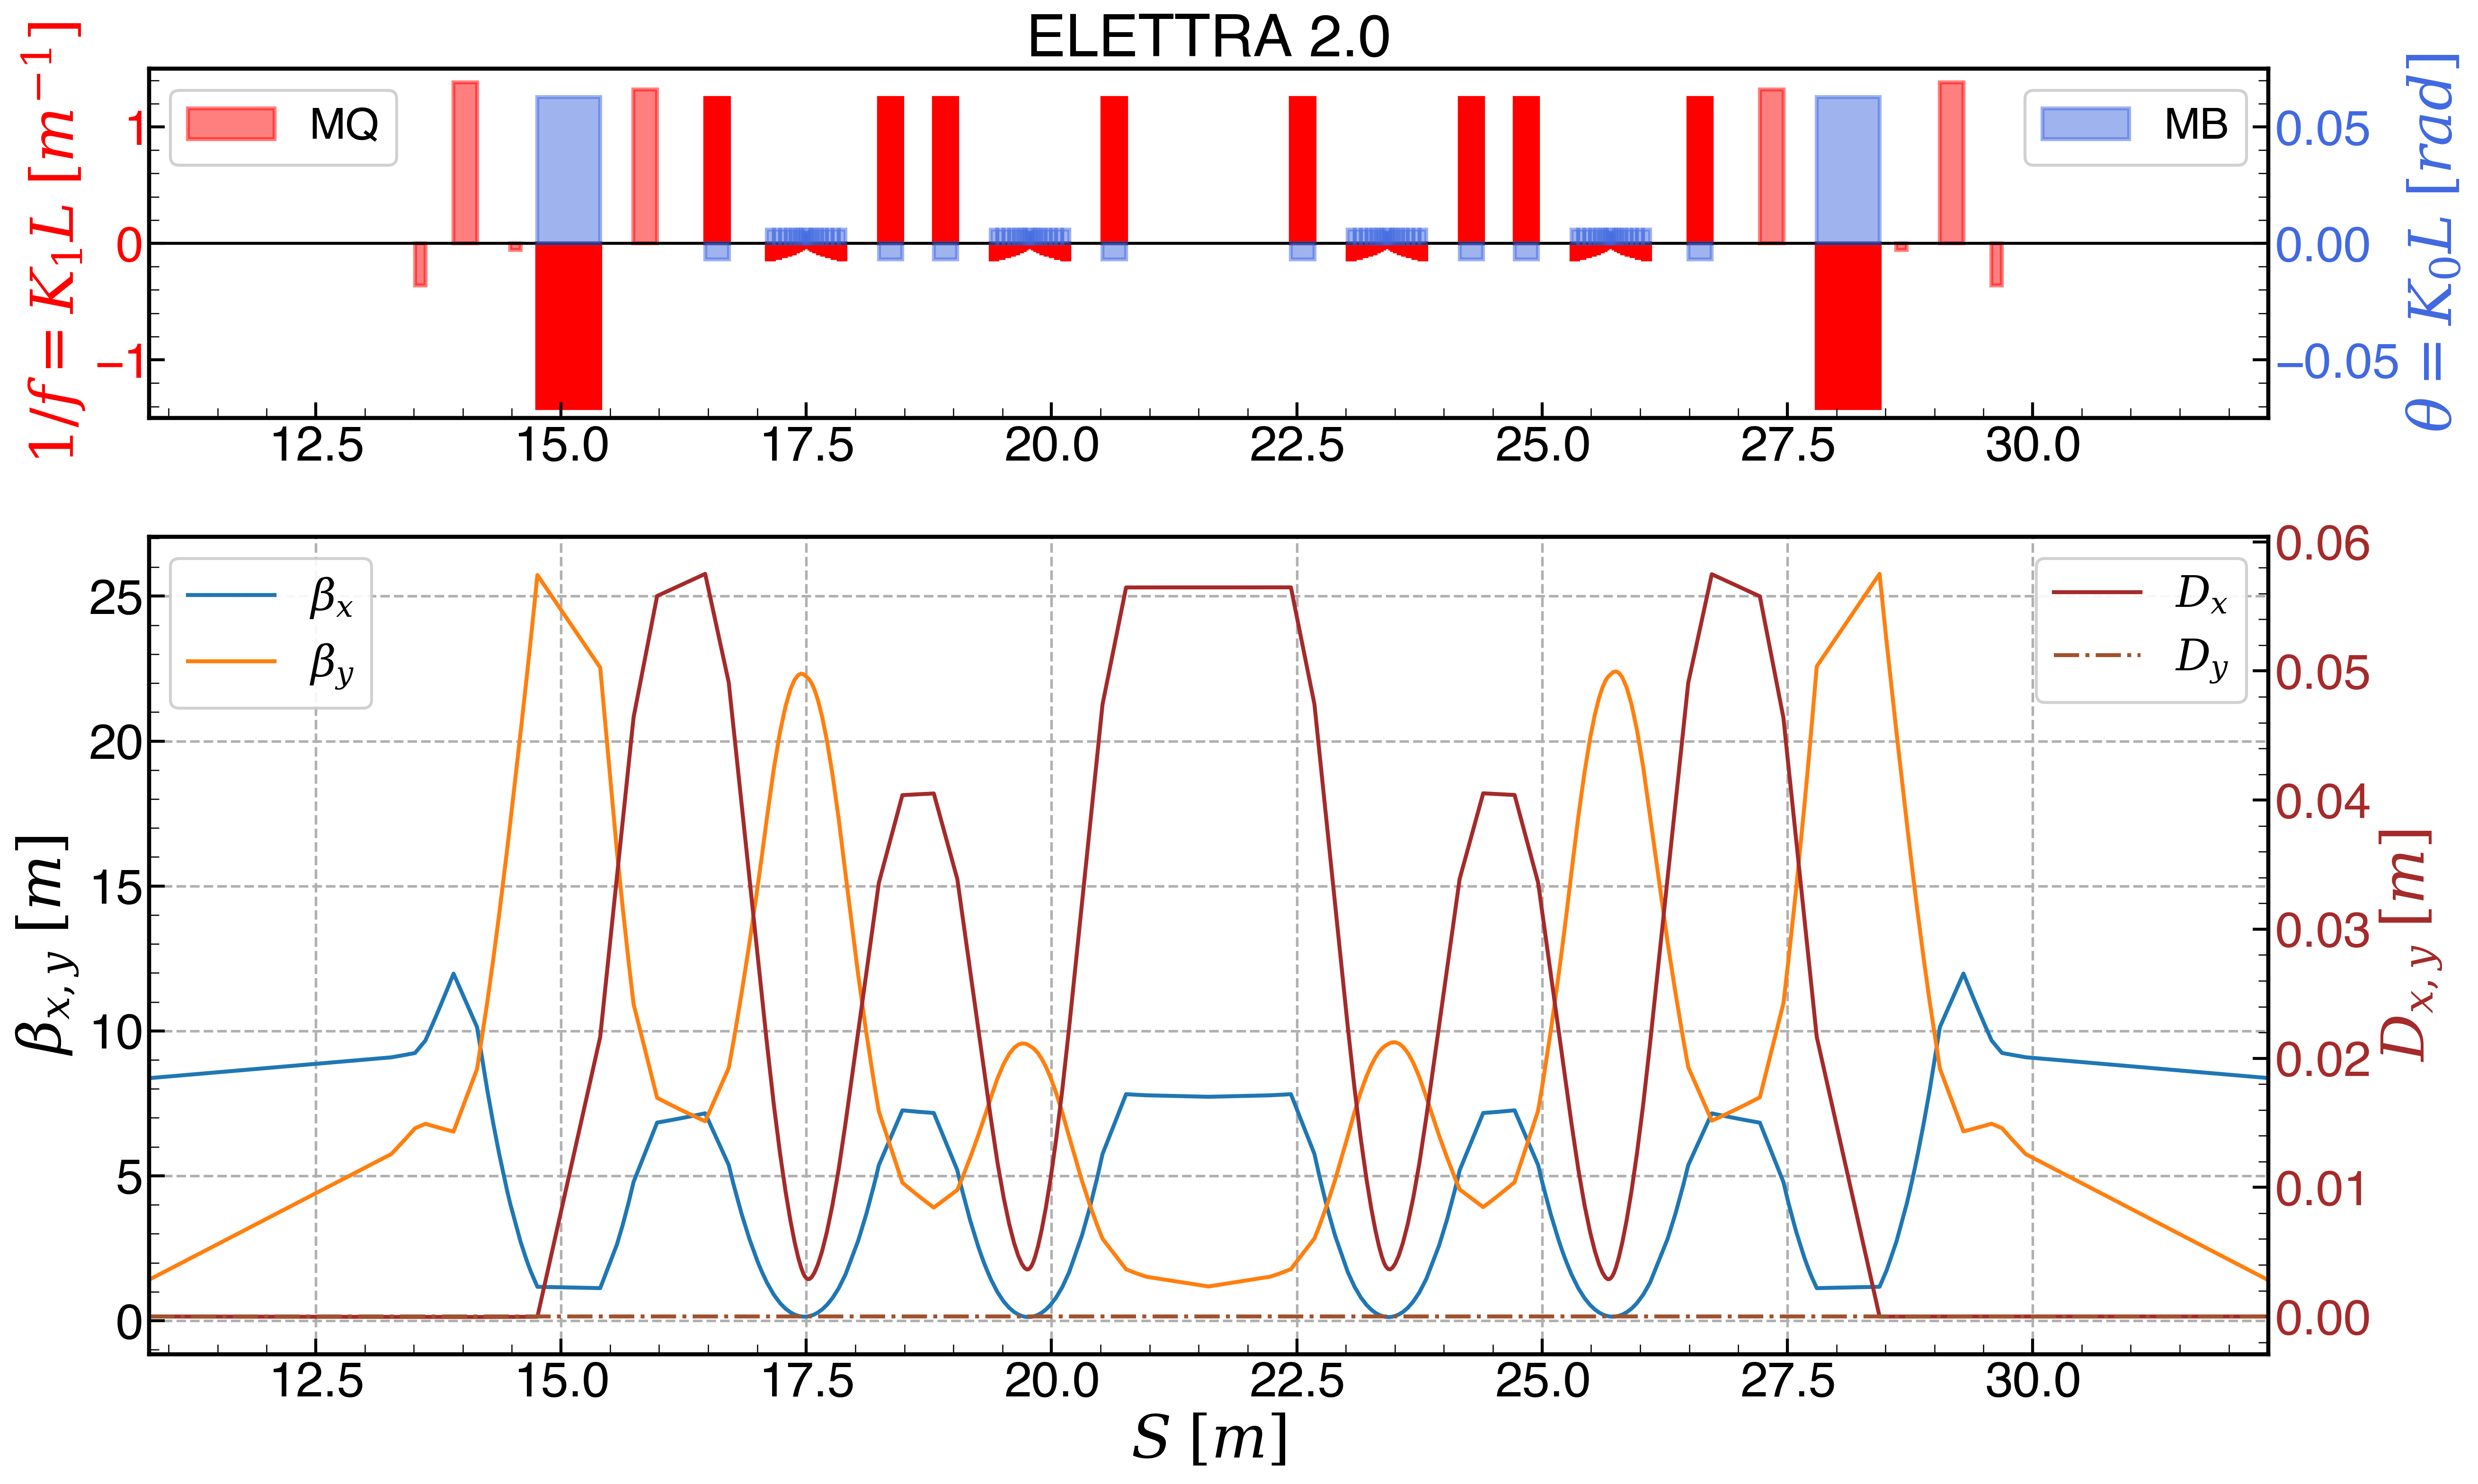

In [12]:
s_start = twiss[twiss.name == "ll:1"]["s"][0]
s_end = twiss[twiss.name == "ll:3"]["s"][0]

fig_lattice = cpymadtools.plotters.LatticePlotter.plot_latwiss(
    madx=madx,
    title="ELETTRA 2.0",
    xlimits=(s_start, s_end),
    disp_ylim=None,
    k0l_lim=(-75 * 1e-3, 75 * 1e-3),
    k1l_lim=(-1.5, 1.5),
    plot_dipole_k1=True,
    lw=2,
    savefig="after_match.pdf",
)

2021-10-19 14:57:57.496 | INFO     | pyhdtoolkit.cpymadtools.plotters:plot_latwiss:638 - Plotting optics functions and machine layout
2021-10-19 14:57:57.496 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:plot_latwiss:639 - Getting Twiss dataframe from cpymad
2021-10-19 14:57:57.983 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:_make_elements_groups:1319 - Getting different element groups dframes from MAD-X twiss table
2021-10-19 14:57:58.048 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:_plot_machine_layout:1191 - Plotting machine layout
2021-10-19 14:57:59.469 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:plot_latwiss:665 - Plotting beta functions
2021-10-19 14:57:59.616 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:plot_latwiss:673 - Plotting dispersion functions
2021-10-19 14:57:59.645 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:plot_latwiss:687 - Setting ylim for dispersion plot
2021-10-19 14:57:59.646 | DEBUG    | pyhdtoolkit.cpymadtools.plotters:plot_latwiss:691 - Setting xlim 

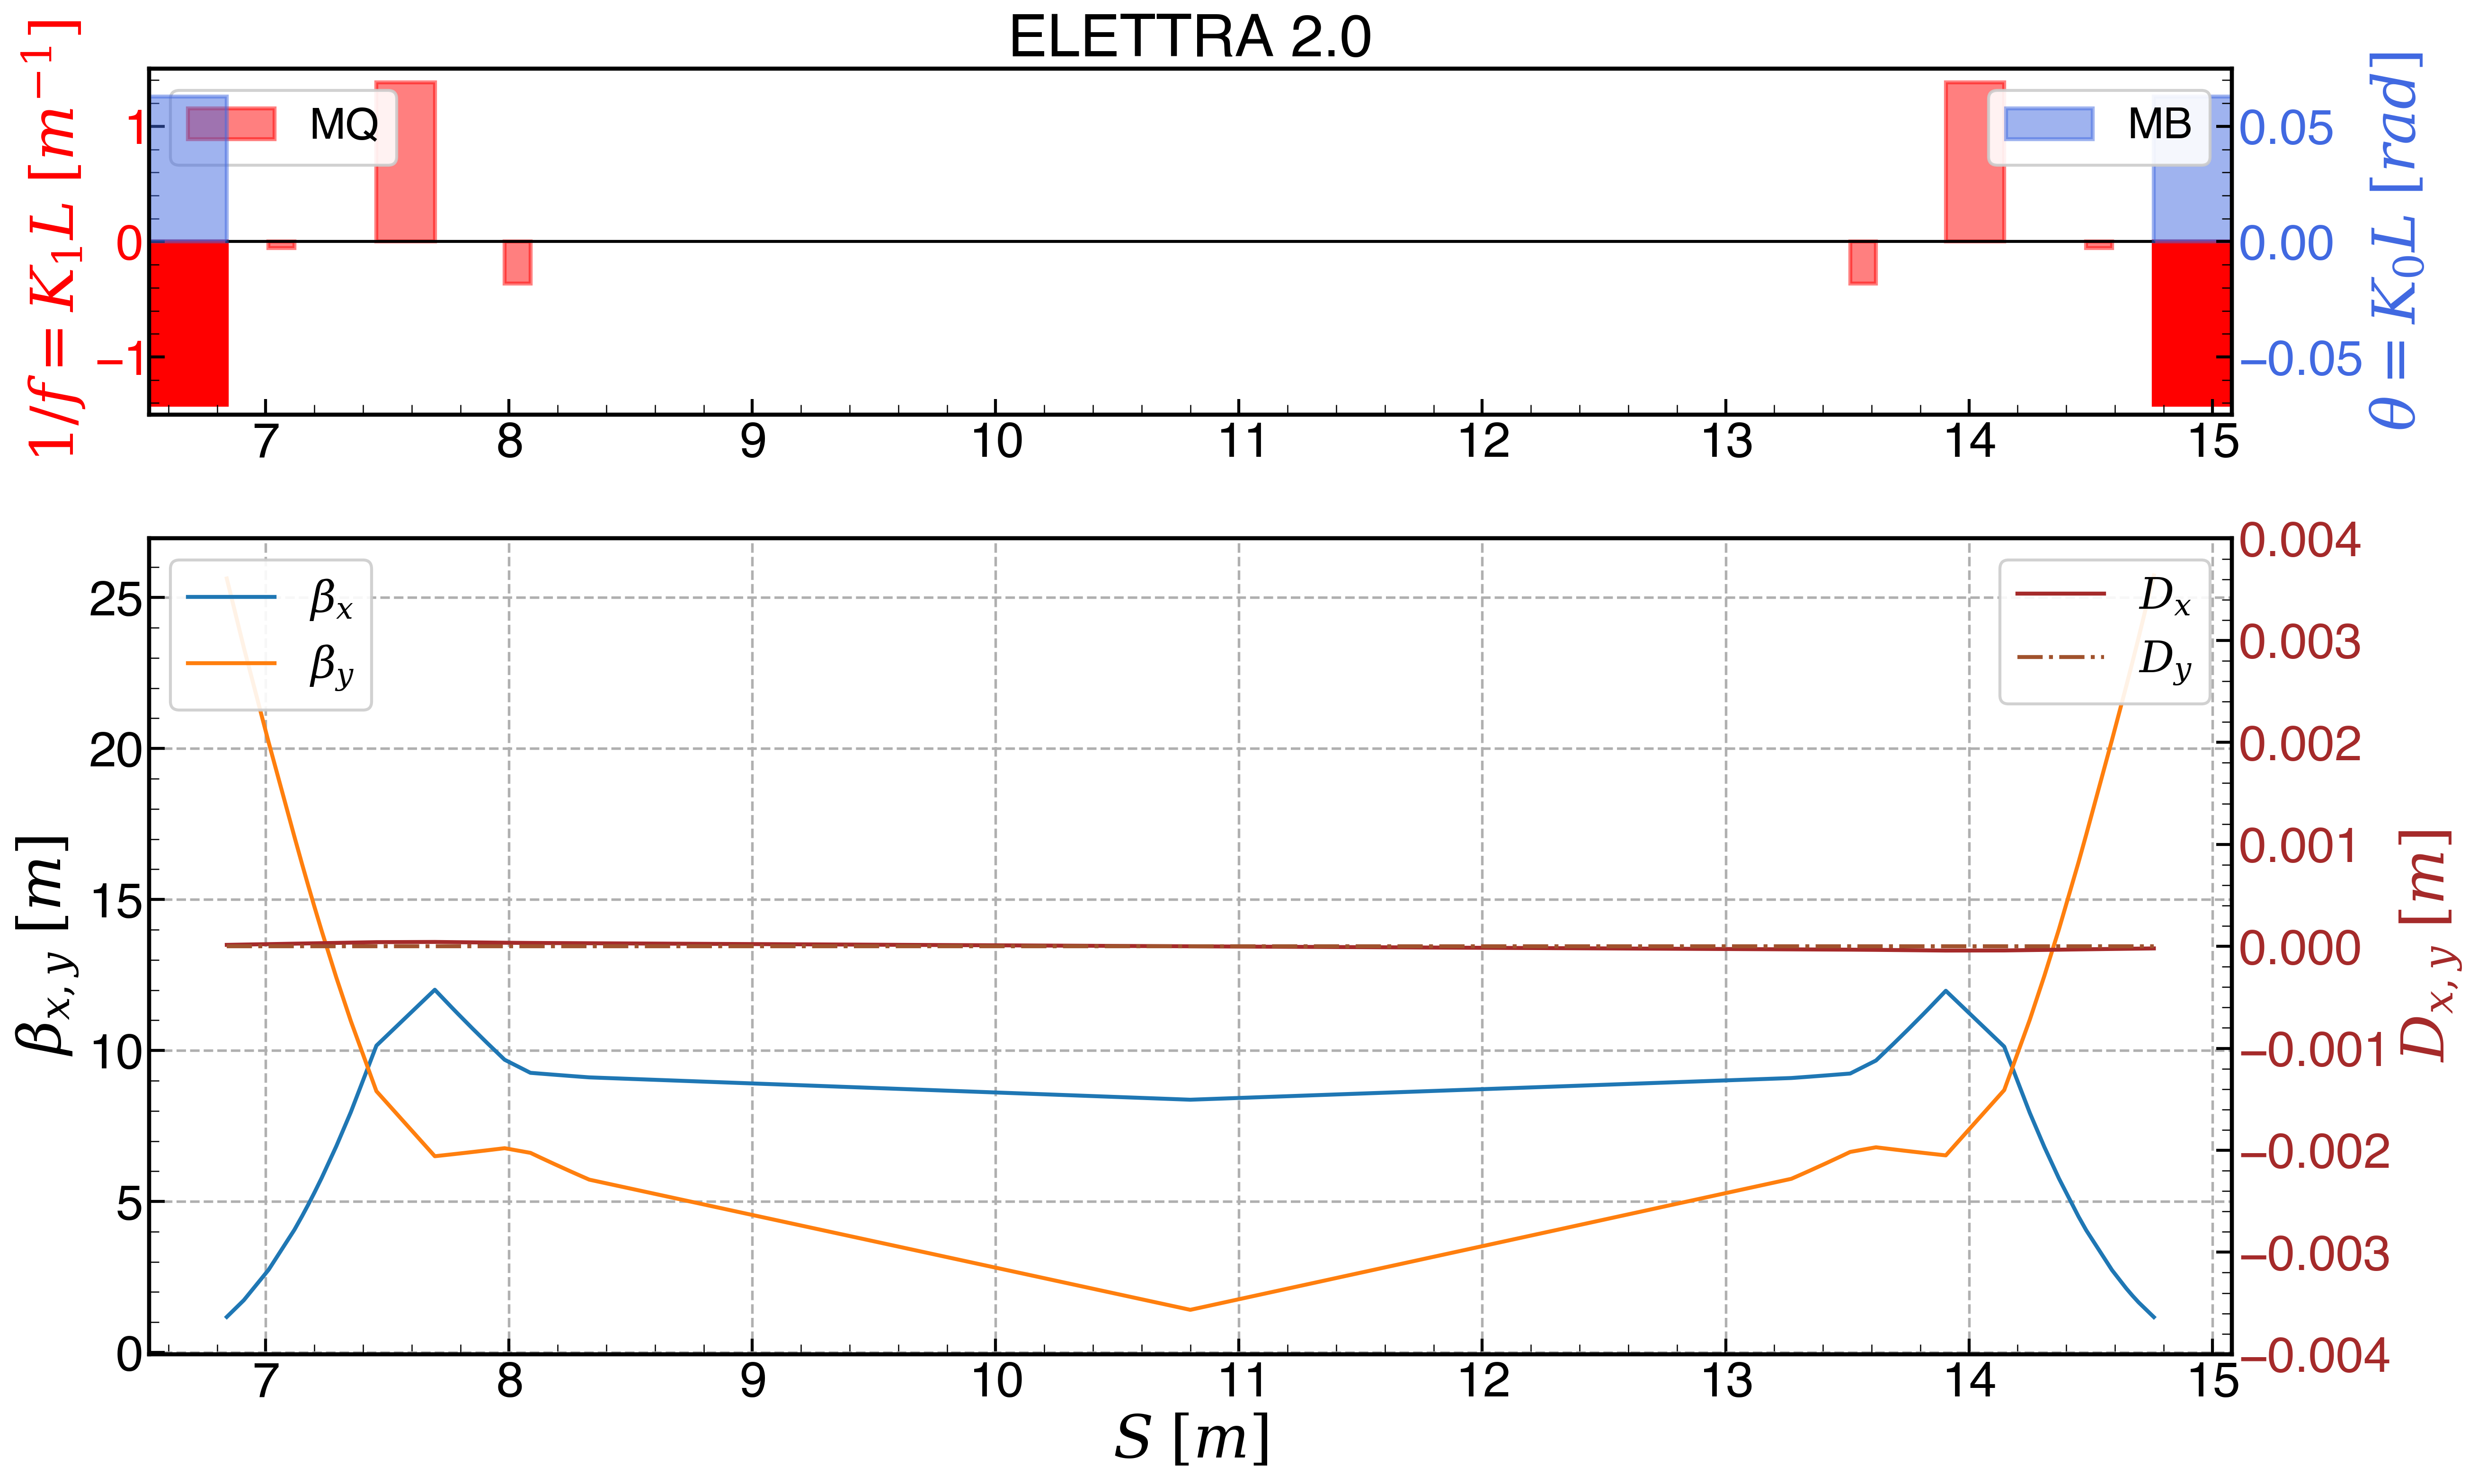

In [13]:
s_start = twiss[twiss.name == "bf1:1"]["s"][0] - twiss[twiss.name == "bf1:1"]["l"][0] / 2
s_end = twiss[twiss.name == "bf1:2"]["s"][0] - twiss[twiss.name == "bf1:2"]["l"][0] / 2

fig_lattice = cpymadtools.plotters.LatticePlotter.plot_latwiss(
    madx=madx,
    title="ELETTRA 2.0",
    xlimits=(s_start, s_end),
    disp_ylim=(-0.004, 0.004),
    k0l_lim=(-75 * 1e-3, 75 * 1e-3),
    k1l_lim=(-1.5, 1.5),
    plot_dipole_k1=True,
    lw=2,
)

In [18]:
# Compute Emittance

madx.command.emit(deltap=madx.globals.deltap)
madx.command.emit(deltap=madx.globals.deltap)

# Get the emittance from the standard output

ex, ey, ez = elettra_toolbox.get_emittances_from_madx_output("stdout.out", to_meters=True)


print(f"Emittance x : {ex*1e12} pm")

Emittance x : 155.66564 pm
